# Case Study For Customer Segmentation
## Initial setup

Importing all required libraries and loading the data

In [307]:
# Import Modules
import pandas as pd 
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import csv
from sklearn.feature_selection import VarianceThreshold
from sklearn.cluster import KMeans
from sklearn import metrics
from scipy.spatial.distance import cdist
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime as dt
import datetime

FILE_NAME = 'information.csv'

input_data = pd.read_csv(FILE_NAME)
display(input_data.head(5))

,customer_id,First Time,Recent Time,# of Orders,# of Orders in last 7 days,# of Orders in last 4 weeks,Amount,Amount in last 7 days,Amount in last 4 weeks,Avg_DistanceFromResturant,Avg_DeliveryTime
0,1269647,6/29/15 10:57,12/10/15 2:18,212,6.0,43.0,138808,4291,26853,1.6,51
1,167631,7/4/15 15:39,12/15/15 14:42,211,8.0,19.0,56404,1925,4177,2.2,42
2,301524,6/26/15 9:56,12/9/15 20:45,189,9.0,33.0,36020,1772,6404,2.5,57
3,1268254,7/1/15 1:51,12/14/15 1:43,184,6.0,37.0,32489,975,7110,3.1,55
4,357161,7/11/15 18:34,12/19/15 23:26,182,4.0,23.0,85150,1738,9958,2.4,36


### Feature Engineering
1. This part helps to get the count of the values of the input data.
2. Added Four Derived Attributes (customer_duration, customer_recency, Avg_Ticket_Value, Customer_Value) to make the feature slection process easier
#### customer_duration
This signifies how much time customer is accustomed with the platform.
#### customer_recency
This signifies the time difference of last order of the data.
#### Avg_Ticket_Value
This signifies the avg spending pattern of the user
#### Customer_Value
This signifies that week by week spending is decreasing or increasing. If spending increases customer value increases and if it decreases then customer value is decreasing.

In [266]:
print("Number of rows: ",input_data.shape[0])
counts = input_data.describe().iloc[0]
display(
    pd.DataFrame(
        counts.tolist(), 
        columns=["Count of values"], 
        index=counts.index.values
    ).transpose()
)

input_data['First Time']=pd.to_datetime(input_data['First Time'], infer_datetime_format=True)
input_data['Recent Time']=pd.to_datetime(input_data['Recent Time'], infer_datetime_format=True)
input_data['customer_duration'] = input_data.apply(lambda x: (datetime.date.today()-x['First Time'].date()).days, axis=1)
input_data['customer_recency'] = input_data.apply(lambda x: (datetime.date.today()-x['Recent Time'].date()).days, axis=1)
input_data['Avg_Ticket_Value'] = input_data['Amount']*1.0/input_data['# of Orders']
input_data['Customer_Value'] = input_data['Amount in last 7 days'] - (input_data['Amount in last 4 weeks']*1.0/4)

('Number of rows: ', 10000)


,customer_id,# of Orders,# of Orders in last 7 days,# of Orders in last 4 weeks,Amount,Amount in last 7 days,Amount in last 4 weeks,Avg_DistanceFromResturant,Avg_DeliveryTime
Count of values,10000.0,10000.0,1923.0,4341.0,10000.0,10000.0,10000.0,10000.0,10000.0


### Feature Selection
Used __SVD__ to remove redundant feature.
1. Prior That  data standardization have been done
2. value = value-min/max-min has been applied to standardize that though Recency weightage should have been calculated seperately in reverse manner (that has been done below)
3. Selection of columns has been done based on _svd components_

In [267]:

input_data['#_of_Orders']=(input_data['# of Orders']-input_data['# of Orders'].min()*1.0)/(input_data['# of Orders'].max()-input_data['# of Orders'].min())
input_data['#_of_Orders_in_last_7_days']=(input_data['# of Orders in last 7 days']-input_data['# of Orders in last 7 days'].min()*1.0)/(input_data['# of Orders in last 7 days'].max()-input_data['# of Orders in last 7 days'].min())
input_data['#_of_Orders_in_last_4_weeks']=(input_data['# of Orders in last 4 weeks']-input_data['# of Orders in last 4 weeks'].min()*1.0)/(input_data['# of Orders in last 4 weeks'].max()-input_data['# of Orders in last 4 weeks'].min())
input_data['Amount_']=(input_data['Amount']-input_data['Amount'].min()*1.0)/(input_data['Amount'].max()-input_data['Amount'].min())
input_data['Amount_in_last_7_days']=(input_data['Amount in last 7 days']-input_data['Amount in last 7 days'].min()*1.0)/(input_data['Amount in last 7 days'].max()-input_data['Amount in last 7 days'].min())
input_data['Amount_in_last_4_weeks']=(input_data['Amount in last 4 weeks']-input_data['Amount in last 4 weeks'].min()*1.0)/(input_data['Amount in last 4 weeks'].max()-input_data['Amount in last 4 weeks'].min())
input_data['Avg_DistanceFromResturant_']=(input_data['Avg_DistanceFromResturant']-input_data['Avg_DistanceFromResturant'].min()*1.0)/(input_data['Avg_DistanceFromResturant'].max()-input_data['Avg_DistanceFromResturant'].min())
input_data['Avg_DeliveryTime_']=(input_data['Avg_DeliveryTime']-input_data['Avg_DeliveryTime'].min()*1.0)/(input_data['Avg_DeliveryTime'].max()-input_data['Avg_DeliveryTime'].min())
input_data['duration']=(input_data['customer_duration']-input_data['customer_duration'].min()*1.0)/(input_data['customer_duration'].max()-input_data['customer_duration'].min())
input_data['recency']=(input_data['customer_recency']-input_data['customer_recency'].min()*1.0)/(input_data['customer_recency'].max()-input_data['customer_recency'].min())
input_data['Avg_Ticket_Value_'] = (input_data['Avg_Ticket_Value']-input_data['Avg_Ticket_Value'].min()*1.0)/(input_data['Avg_Ticket_Value'].max()-input_data['Avg_Ticket_Value'].min())
input_data['Customer_Value_'] = (input_data['Customer_Value']-input_data['Customer_Value'].min()*1.0)/(input_data['Customer_Value'].max()-input_data['Customer_Value'].min())

In [268]:
from sklearn.decomposition import TruncatedSVD
dataframe = input_data[['#_of_Orders','#_of_Orders_in_last_7_days','#_of_Orders_in_last_4_weeks','Amount_','Amount_in_last_7_days','Amount_in_last_4_weeks','Avg_DistanceFromResturant_','Avg_DeliveryTime_','duration','recency','Avg_Ticket_Value_','Customer_Value_']]
svd = TruncatedSVD(n_components=9, n_iter=15, random_state=42)
dataframe=dataframe.dropna()
svd.fit(dataframe.values.tolist()) 
#print(svd.explained_variance_ratio_)
var_ratios=svd.explained_variance_ratio_
#print(svd.singular_values_)
display( "get the dimensions coeff" 
" ".join([
    "%+0.3f*%s" % (coef, feat) 
    for coef, feat in zip(svd.components_[0], dataframe.columns)
]))

'+0.089*#_of_Ordersget the dimensions coeff +0.064*#_of_Orders_in_last_7_daysget the dimensions coeff +0.093*#_of_Orders_in_last_4_weeksget the dimensions coeff +0.045*Amount_get the dimensions coeff +0.061*Amount_in_last_7_daysget the dimensions coeff +0.062*Amount_in_last_4_weeksget the dimensions coeff +0.482*Avg_DistanceFromResturant_get the dimensions coeff +0.336*Avg_DeliveryTime_get the dimensions coeff +0.627*durationget the dimensions coeff +0.145*recencyget the dimensions coeff +0.035*Avg_Ticket_Value_get the dimensions coeff +0.457*Customer_Value_'

Based on __SVD__ From This data set following columns has been selected 
1. #_of_Orders
3. #_of_Orders_in_last_4_weeks
4. Avg_DistanceFromResturant
5. Avg_DeliveryTime
6. customer_duration
7. customer_recency 

Here #_of_Orders_in_last_4_weeks contains NA, Based on Perception, if no order data available we can can consider that no order has been placed in that period.
P.S - Refinement can be done, based on Amount (if amount==0 then order 0 else, populate based on Avg ticket value)

# Feature Selection
Based on SVD results we will select 
1. No of Orders
3. No of Orders in last 4 weeks
4. Avg_DistanceFromResturant
5. Avg_DeliveryTime
6. customer_duration
7. customer_recency

For further analysis

In [269]:
finaldataframe = input_data[['customer_id','#_of_Orders','#_of_Orders_in_last_4_weeks','Avg_DistanceFromResturant','Avg_DeliveryTime','customer_duration','customer_recency','Customer_Value']]
print "Columns Having None :",finaldataframe.columns[finaldataframe.isna().any()].tolist()
finaldataframe=finaldataframe.fillna(0)

Columns Having None : ['#_of_Orders_in_last_4_weeks']


In [270]:
finaldataframe.shape

(10000, 8)

In [304]:
display(finaldataframe.head())

,customer_id,# of Orders,# of Orders in last 4 weeks,Avg_DistanceFromResturant,Avg_DeliveryTime,customer_duration,customer_recency,Avg_Ticket_Value,Customer_Value,cluster_id,recency,duration
0,1269647,212,43.0,1.6,51,1191,1027,654.754717,-2422.25,4,0.844749,0.888889
1,167631,211,19.0,2.2,42,1186,1022,267.317536,880.75,3,0.867580,0.865741
2,301524,189,33.0,2.5,57,1194,1028,190.582011,171.00,8,0.840183,0.902778
3,1268254,184,37.0,3.1,55,1189,1023,176.570652,-802.50,7,0.863014,0.879630
4,357161,182,23.0,2.4,36,1179,1018,467.857143,-751.50,7,0.885845,0.833333


#### Histogram Analysis for few relevel attributes to check the distribution of the data

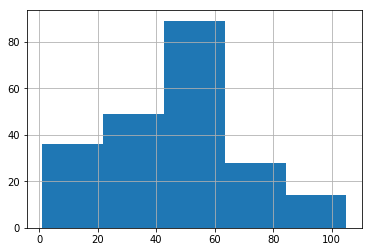

In [272]:
finaldataframe.customer_id.groupby(finaldataframe.customer_duration).nunique().hist(bins=5);

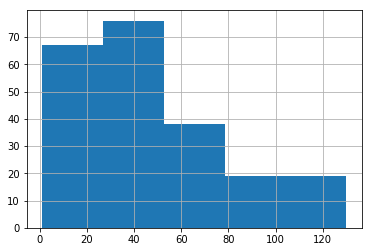

In [273]:
finaldataframe.customer_id.groupby(finaldataframe.customer_recency).nunique().hist(bins=5);

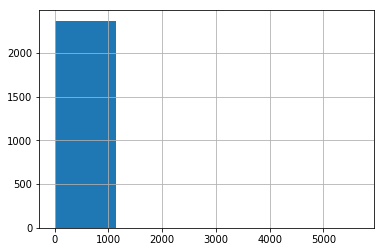

In [291]:
finaldataframe.customer_id.groupby(finaldataframe.Customer_Value).nunique().hist(bins=5);

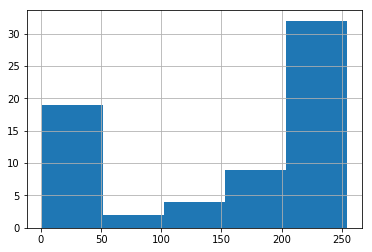

In [292]:
finaldataframe.customer_id.groupby(finaldataframe.Avg_DeliveryTime).nunique().hist(bins=5);

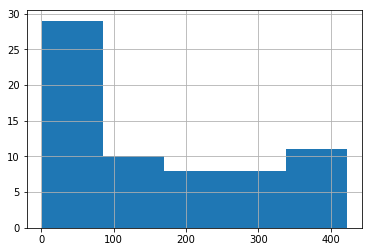

In [293]:
finaldataframe.customer_id.groupby(finaldataframe.Avg_DistanceFromResturant).nunique().hist(bins=5);

# Clustering of the Users

Optimal value of k has been found using __elbow method__ to determine optimal value of k

In [294]:
finaldataframe = input_data[['#_of_Orders','#_of_Orders_in_last_4_weeks','Avg_DistanceFromResturant','Avg_DeliveryTime','customer_duration','customer_recency','Customer_Value']]
print "Columns Having None :",finaldataframe.columns[finaldataframe.isna().any()].tolist()
finaldataframe=finaldataframe.fillna(0)

Columns Having None : ['#_of_Orders_in_last_4_weeks']


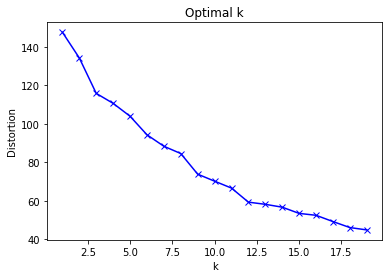

In [295]:
data_x = finaldataframe.values
distortions = []
K = range(1,20)
for k in K:
    kmeanModel = KMeans(n_clusters=k).fit(data_x)
    kmeanModel.fit(data_x)
    distortions.append(sum(np.min(cdist(data_x, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / data_x.shape[0])

plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('Optimal k')
plt.show()

In [296]:
FINAL_K = 12
kmeanModel = KMeans(n_clusters=FINAL_K).fit(data_x)

In [297]:
customer_labels = kmeanModel.labels_

In [298]:
finaldataframe = input_data[['customer_id','# of Orders','# of Orders in last 4 weeks','Avg_DistanceFromResturant','Avg_DeliveryTime','customer_duration','customer_recency','Avg_Ticket_Value','Customer_Value']]

In [299]:
rows = finaldataframe.shape[0]

In [300]:
finaldataframe['cluster_id']=customer_labels

/home/ubuntu/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [301]:
j=finaldataframe.groupby(['cluster_id']).size()*100.0/finaldataframe.shape[0]
j=j.reset_index()
j['percentages']=j[0]
j=j.drop([0], axis=1)
display(j)

,cluster_id,percentages
0,0,27.60
1,1,8.94
2,2,0.17
3,3,2.17
4,4,0.46
5,5,31.11
6,6,0.03
7,7,2.52
8,8,6.00
9,9,0.04


In [302]:
finaldataframe=finaldataframe.fillna(0)
finaldataframe['recency']=(finaldataframe.customer_recency.max()-finaldataframe['customer_recency'])*1.0/abs(finaldataframe.customer_recency.min()-finaldataframe.customer_recency.max())
finaldataframe['duration']=(finaldataframe['customer_duration']-finaldataframe.customer_duration.min())*1.0/abs(finaldataframe.customer_duration.min()-finaldataframe.customer_duration.max())
user_segmenst=finaldataframe.groupby(['cluster_id'])['# of Orders','# of Orders in last 4 weeks','Avg_DistanceFromResturant','Avg_DeliveryTime','duration','recency','Avg_Ticket_Value','Customer_Value'].agg(['size','mean','median'])

### Results
Based on the optimal value of k=12, derived 12 clusters from the given data. Bussines information can be retrived from the statistical values of the aatribute of the each cluster. Added Average Ticket Value with this stat to retrive bussines information easily though it's not been used in the clustering technique.

In [305]:
display(user_segmenst.reset_index())

cluster_id # of Orders                   # of Orders in last 4 weeks  \
                     size       mean median                        size   
0           0        2760   2.421014      1                        2760   
1           1         894  12.237136      6                         894   
2           2          17  20.941176     15                          17   
3           3         217  15.087558      8                         217   
4           4          46  36.804348     25                          46   
5           5        3111   2.320476      1                        3111   
6           6           3  48.333333     33                           3   
7           7         252  23.896825     15                         252   
8           8         600  10.825000      6                         600   
9           9           4  25.250000     20                           4   
10         10          92  17.434783      6                          92   
11         11        2004  12.740020      8                        2004   

                     Avg_DistanceFromResturant                     ...     \
         mean median                      size      mean median    ...      
0    0.000000    0.0                      2760  2.374275    2.4    ...      
1    3.371365    2.0                       894  2.336242    2.3    ...      
2    7.470588    3.0                        17  2.605882    2.4    ...      
3    3.990783    3.0                       217  2.388018    2.3    ...      
4    9.934783    7.0                        46  2.347826    2.3    ...      
5    0.652523    0.0                      3111  2.355031    2.4    ...      
6   10.666667    9.0                         3  2.866667    2.5    ...      
7    6.297619    4.0                       252  2.317857    2.3    ...      
8    3.140000    2.0                       600  2.306500    2.3    ...      
9   10.250000    9.5                         4  2.450000    2.1    ...      
10   5.228261    3.0                        92  2.439130    2.5    ...      
11   1.677645    1.0                      2004  2.351597    2.4    ...      

    duration recency                     Avg_Ticket_Value               \
      median    size      mean    median             size         mean   
0   0.722222    2760  0.332577  0.342466             2760   360.405155   
1   0.564815     894  0.814869  0.817352              894   491.896689   
2   0.671296      17  0.843943  0.840183               17  1361.537628   
3   0.638889     217  0.861478  0.867580              217   547.605561   
4   0.733796      46  0.829561  0.817352               46  1022.674090   
5   0.347222    3111  0.704403  0.707763             3111   316.697457   
6   0.870370       3  0.873668  0.867580                3  2109.159596   
7   0.717593     252  0.819943  0.826484              252   666.797693   
8   0.523148     600  0.860906  0.863014              600   338.279284   
9   0.400463       4  0.829909  0.805936                4  3341.809112   
10  0.504630      92  0.858199  0.853881               92   742.273857   
11  0.787037    2004  0.743046  0.753425             2004   265.635306   

                Customer_Value                         
         median           size         mean    median  
0    281.000000           2760     0.000000     0.000  
1    448.464286            894  -224.405201  -210.125  
2    827.428571             17  2371.426471  2305.250  
3    497.800000            217   612.490783   574.750  
4    779.260593             46 -1387.016304 -1246.000  
5    231.000000           3111   -11.572485     0.000  
6    852.606061              3  5927.500000  6391.500  
7    559.675000            252  -616.960317  -577.375  
8    303.718623            600   248.562917   234.000  
9   1292.164835              4 -3765.937500 -3672.375  
10   631.079474             92  1218.929348  1163.625  
11   211.660920           2004   -12.514346     0.000  

[12 rows x 25 columns]

# Seven days spend Prediction
Last Seven Days Spend Prediction has been performed in this part.
Similar Attribute Cleaning and Generation has been performend.

In [308]:
print("Number of rows: ",input_data.shape[0])
counts = input_data.describe().iloc[0]
display(
    pd.DataFrame(
        counts.tolist(), 
        columns=["Count of values"], 
        index=counts.index.values
    ).transpose()
)

input_data['First Time']=pd.to_datetime(input_data['First Time'], infer_datetime_format=True)
input_data['Recent Time']=pd.to_datetime(input_data['Recent Time'], infer_datetime_format=True)
input_data['customer_duration'] = input_data.apply(lambda x: (datetime.date.today()-x['First Time'].date()).days, axis=1)
input_data['customer_recency'] = input_data.apply(lambda x: (datetime.date.today()-x['Recent Time'].date()).days, axis=1)
input_data['Avg_Ticket_Value'] = input_data['Amount']*1.0/input_data['# of Orders']
input_data['Avg_Week_Value'] = (input_data['Amount in last 4 weeks']*1.0)/4

('Number of rows: ', 10000)


,customer_id,# of Orders,# of Orders in last 7 days,# of Orders in last 4 weeks,Amount,Amount in last 7 days,Amount in last 4 weeks,Avg_DistanceFromResturant,Avg_DeliveryTime
Count of values,10000.0,10000.0,1923.0,4341.0,10000.0,10000.0,10000.0,10000.0,10000.0


In [316]:
Input_relevent_data = input_data[['customer_id','# of Orders','# of Orders in last 7 days','# of Orders in last 4 weeks','Amount','Amount in last 7 days','Amount in last 4 weeks','Avg_DistanceFromResturant','Avg_DeliveryTime','customer_duration','customer_recency','Avg_Ticket_Value','Avg_Week_Value']]

In [317]:
Input_relevent_data.shape

(10000, 13)

# Data inspection
##### This step is to check that what is the percentage of data contains NA, AS '# of Orders in last 7 days' contains 80% NA and that is correlated with Y value
##### populated 0 in those places, to make those data usable

In [318]:
Input_relevent_data.isna().sum()

customer_id                       0
# of Orders                       0
# of Orders in last 7 days     8077
# of Orders in last 4 weeks    5659
Amount                            0
Amount in last 7 days             0
Amount in last 4 weeks            0
Avg_DistanceFromResturant         0
Avg_DeliveryTime                  0
customer_duration                 0
customer_recency                  0
Avg_Ticket_Value                  0
Avg_Week_Value                    0
dtype: int64

In [324]:
Input_relevent_data=Input_relevent_data.fillna(0)

##### Relevent Data description has been given in this space

In [325]:
Input_relevent_data.describe()

,customer_id,# of Orders,# of Orders in last 7 days,# of Orders in last 4 weeks,Amount,Amount in last 7 days,Amount in last 4 weeks,Avg_DistanceFromResturant,Avg_DeliveryTime,customer_duration,customer_recency,Avg_Ticket_Value,Avg_Week_Value
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,6.714023e+05,7.006200,0.333600,1.388100,2253.273600,109.497500,455.491200,2.35620,36.914300,1124.586700,1074.401100,360.005686,113.872800
std,3.901880e+05,13.118619,0.910052,3.041842,5136.484499,397.055277,1237.872749,0.97492,13.175413,52.364999,48.544543,373.105550,309.468187
min,2.800000e+01,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-0.80000,15.000000,1001.000000,995.000000,0.083333,0.000000
25%,3.365148e+05,1.000000,0.000000,0.000000,279.000000,0.000000,0.000000,1.70000,26.000000,1081.000000,1035.000000,138.522059,0.000000
50%,6.683395e+05,2.000000,0.000000,0.000000,688.000000,0.000000,0.000000,2.40000,36.500000,1133.000000,1061.000000,281.000000,0.000000
75%,1.005002e+06,7.000000,0.000000,1.000000,2040.000000,0.000000,398.000000,3.02500,47.000000,1171.000000,1107.000000,478.465909,99.500000
max,1.355445e+06,212.000000,14.000000,46.000000,138808.000000,10150.000000,26853.000000,5.90000,83.000000,1217.000000,1214.000000,9906.500000,6713.250000


###### Data Extraction
Data Extraction has been done for attribute analysis for the experiment

In [328]:
Target_Y = Input_relevent_data['Amount in last 7 days']
Target_X = Input_relevent_data.drop(['Amount in last 7 days','customer_id'], axis=1)

# Feature Selection
Based on __svd__ results we will select 

In [343]:
from sklearn.decomposition import TruncatedSVD
dataframe = Target_X
svd = TruncatedSVD(n_components=9, n_iter=15, random_state=42)
dataframe=dataframe.dropna()
svd.fit(dataframe.values.tolist()) 
#print(svd.explained_variance_ratio_)
var_ratios=svd.explained_variance_ratio_
#print(svd.singular_values_)
display("get the dimensions coeff" )
display( 
" ".join([
    "%+0.3f*%s" % (coef, feat) 
    for coef, feat in zip(svd.components_[0], dataframe.columns)
]))





'get the dimensions coeff'

'+0.002*# of Orders +0.000*# of Orders in last 7 days +0.000*# of Orders in last 4 weeks +0.976*Amount +0.176*Amount in last 4 weeks +0.000*Avg_DistanceFromResturant +0.003*Avg_DeliveryTime +0.087*customer_duration +0.079*customer_recency +0.041*Avg_Ticket_Value +0.044*Avg_Week_Value'

#### Experiment With Linear Regression

In [345]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split

Target_X = Input_relevent_data.drop(['# of Orders','Amount in last 7 days','customer_id','# of Orders in last 4 weeks','Avg_DistanceFromResturant','Avg_DeliveryTime'], axis=1)
Target_Y = Input_relevent_data['Amount in last 7 days']

x_train , x_test , y_train , y_test = train_test_split(Target_X , Target_Y , test_size = 0.10,random_state =2)
reg.fit(x_train,y_train)
print reg.score(x_test,y_test)

0.6473710258221992


#### Experiment With Gradient Boosting Regression

In [361]:
from sklearn import ensemble
clf = ensemble.GradientBoostingRegressor(n_estimators = 400, max_depth = 5, min_samples_split = 2,
          learning_rate = 0.1, loss = 'ls')
clf.fit(x_train, y_train)
print clf.score(x_test,y_test)
y_pred = clf.predict(x_test)

0.7725263774042093


## Result
#### Comparing R2 value  and mean sq error for performance analysis

In [374]:
from sklearn.metrics import r2_score
print 'r2 value from Gradient Boosting ',r2_score(y_test,y_pred)
y_pred2 = reg.predict(x_test)
print 'r2 value from Linear Regression ',r2_score(y_test,y_pred2)
from sklearn.metrics import mean_squared_error
display('MSE value from Gradient Boosting',mean_squared_error(y_test, y_pred))
display('MSE value from Linear Regression', mean_squared_error(y_test, y_pred2))

r2 value from Gradient Boosting  0.7725263774042093
r2 value from Linear Regression  0.6473710258221992


'MSE value from Gradient Boosting'

33376.296404770495

'MSE value from Linear Regression'

51739.8414319983